#ELL793 Assignment 2
**Problem 1: MNIST Classification & Regularisation**<br>
Abhinava Sikdar 2017MT10724 <br>
Yashank Singh 2017MT10756

Importing libraries and checking for CUDA

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from google.colab import files
import numpy as np
print('Is CUDA available', torch.cuda.is_available())
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))

Is CUDA available True
Torch 1.7.0+cu101 CUDA 10.1
Device: cuda:0


##Handling Data

In [2]:
data_path='../data/'
mnist=datasets.MNIST(data_path, train= True, download=True, transform=transforms.ToTensor())
mnist_val=datasets.MNIST(data_path, train=False, download= True, transform=transforms.ToTensor())

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


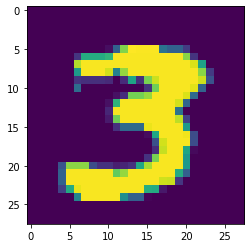

In [3]:
img, label = mnist[27]
plt.imshow(img.permute(1, 2, 0).squeeze())
plt.show()

In [4]:
mnist_stack = torch.stack([img for img, _ in mnist], dim=3)
print('Shape of the MNIST stack is',mnist_stack.shape)
mean= mnist_stack.view(1,-1).mean(dim=1)
std= mnist_stack.view(1,-1).std(dim=1)
print('Mean of training data is', mean)
print('Standard deviation of training data is', std)

Shape of the MNIST stack is torch.Size([1, 28, 28, 60000])
Mean of training data is tensor([0.1307])
Standard deviation of training data is tensor([0.3081])


In [5]:
mnist_transformed = datasets.MNIST(data_path,train=True,download=False, transform=transforms.Compose([
                                                                                                      transforms.ToTensor(),transforms.Normalize(mean,std)
]))
mnist_val_transformed = datasets.MNIST(data_path,train=False,download=False, transform=transforms.Compose([
                                                                                                      transforms.ToTensor(),transforms.Normalize(mean,std)
]))

## Fully Connected Models

Hyperparameters & Dimensions:

In [6]:
input_dim=784
output_dim=10
batch_size=512
val_batch_size=10000
num_epochs=250
learning_rate=5*1e-5

dev=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing DataLoaders:

In [7]:
train_loader=torch.utils.data.DataLoader(mnist_transformed,batch_size=batch_size,shuffle=True)
train_acc_loader=torch.utils.data.DataLoader(mnist_transformed,batch_size=60000,shuffle=False)
val_loader = torch.utils.data.DataLoader(mnist_val_transformed, batch_size=val_batch_size, shuffle=False)

###Unregularised Model:

In [8]:
model= torch.nn.Sequential(
    torch.nn.Linear(input_dim,500),
    torch.nn.ReLU(),
    torch.nn.Linear(500,500),
    torch.nn.ReLU(),
    torch.nn.Linear(500,output_dim),
    torch.nn.Softmax(dim=1)
)

model=model.to(dev)

loss_func= torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Training Loop w/o Regularisation:

In [9]:
val_acc=[]
train_acc=[]
epochs=[]

In [10]:
for i in range(num_epochs):

  for imgs, labels in train_loader:
    if dev is not None:
      imgs,labels=imgs.to(dev),labels.to(dev)
    out= model(imgs.view(imgs.shape[0],-1))
    loss=loss_func(out,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  correct_val = 0
  total_val = 0
  correct_train_acc=0
  total_train_acc=0

  with torch.no_grad():
    for imgs, labels in val_loader:
      if dev is not None:
        imgs,labels=imgs.to(dev),labels.to(dev)
      outputs = model(imgs.view(val_batch_size, -1)) 
      _, predicted = torch.max(outputs, dim=1) 
      total_val += labels.shape[0]
      correct_val += int((predicted == labels).sum())
    val_acc.append(correct_val/total_val)

    for train_acc_imgs,train_acc_labels in train_acc_loader:
      if dev is not None:
        train_acc_imgs,train_acc_labels=train_acc_imgs.to(dev),train_acc_labels.to(dev)
      train_acc_out=model(train_acc_imgs.view(train_acc_imgs.shape[0],-1))
      _, train_acc_predicted = torch.max(train_acc_out, dim=1)
      total_train_acc += train_acc_labels.shape[0]
      correct_train_acc += int((train_acc_predicted == train_acc_labels).sum())
    train_acc.append(correct_train_acc/total_train_acc)
  epochs.append(i)

  if i%5==0:
    print("Epoch: %d, Loss: %f" % (i, float(loss)))
    print("Train Accuracy: ", correct_train_acc / total_train_acc)
    print("Validation Accuracy: ", correct_val / total_val)

Epoch: 0, Loss: 1.680936
Train Accuracy:  0.79785
Validation Accuracy:  0.8084
Epoch: 5, Loss: 1.559071
Train Accuracy:  0.9262166666666667
Validation Accuracy:  0.9277
Epoch: 10, Loss: 1.529081
Train Accuracy:  0.94355
Validation Accuracy:  0.9396
Epoch: 15, Loss: 1.516277
Train Accuracy:  0.95385
Validation Accuracy:  0.9483
Epoch: 20, Loss: 1.479964
Train Accuracy:  0.9609166666666666
Validation Accuracy:  0.9525
Epoch: 25, Loss: 1.490749
Train Accuracy:  0.96615
Validation Accuracy:  0.9581
Epoch: 30, Loss: 1.519334
Train Accuracy:  0.9714333333333334
Validation Accuracy:  0.9633
Epoch: 35, Loss: 1.474357
Train Accuracy:  0.97555
Validation Accuracy:  0.9659
Epoch: 40, Loss: 1.472972
Train Accuracy:  0.97865
Validation Accuracy:  0.9683
Epoch: 45, Loss: 1.499289
Train Accuracy:  0.9812166666666666
Validation Accuracy:  0.969
Epoch: 50, Loss: 1.495492
Train Accuracy:  0.9835
Validation Accuracy:  0.9716
Epoch: 55, Loss: 1.513082
Train Accuracy:  0.98485
Validation Accuracy:  0.9738


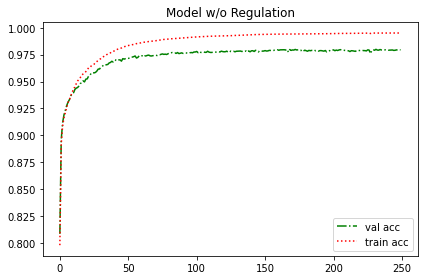

In [11]:
plt.plot(epochs, val_acc, label="val acc", color="green", linestyle='-.')
plt.plot(epochs, train_acc, label="train acc", color="red",linestyle=':')
plt.title("Model w/o Regulation")
plt.legend()
plt.tight_layout()
plt.savefig('unregularised.png',dpi=600)
plt.show()
torch.save(val_acc, 'val_acc.pt')
torch.save(train_acc, 'train_acc.pt')

### Model w/ $l_2$ Regularisation:

In [ ]:
lambd = torch.tensor(7e-3)

In [ ]:
L2_model= torch.nn.Sequential(
    torch.nn.Linear(input_dim,500),
    torch.nn.ReLU(),
    torch.nn.Linear(500,500),
    torch.nn.ReLU(),
    torch.nn.Linear(500,output_dim),
    torch.nn.Softmax(dim=1)
)

L2_model=L2_model.to(dev)

L2_loss_func= torch.nn.CrossEntropyLoss()
L2_optimizer = torch.optim.Adam(L2_model.parameters(), lr=learning_rate,weight_decay=lambd)

Training Loop w/ $l_2$ Regularisation:

In [ ]:
val_acc1=[]
train_acc1=[]
epochs=[]

In [ ]:
for i in range(num_epochs):

  for imgs, labels in train_loader:
    if dev is not None:
      imgs,labels=imgs.to(dev),labels.to(dev)
    out= L2_model(imgs.view(imgs.shape[0],-1))
    L2_loss=L2_loss_func(out,labels)

    ## Why not do L2 regularisation manually? https://stackoverflow.com/questions/61215600/speed-of-l2-regularization-on-pytorch
    #Calculating & Adding the regulatision term to the loss
    #Reg_term = torch.tensor(0.).to(dev)
    #for param in L2_model.parameters():
    #  Reg_term += torch.norm(param)
    #L2_loss += lambd * Reg_term

    L2_optimizer.zero_grad()
    L2_loss.backward()
    L2_optimizer.step()
  
  correct_val = 0
  total_val = 0
  correct_train_acc=0
  total_train_acc=0

  with torch.no_grad():
    for imgs, labels in val_loader:
      if dev is not None:
        imgs,labels=imgs.to(dev),labels.to(dev)
      outputs = L2_model(imgs.view(val_batch_size, -1)) 
      _, predicted = torch.max(outputs, dim=1) 
      total_val += labels.shape[0]
      correct_val += int((predicted == labels).sum())
    val_acc1.append(correct_val/total_val)

    for train_acc_imgs,train_acc_labels in train_acc_loader:
      if dev is not None:
        train_acc_imgs,train_acc_labels=train_acc_imgs.to(dev),train_acc_labels.to(dev)
    train_acc_out= L2_model(train_acc_imgs.view(train_acc_imgs.shape[0],-1))
    _, train_acc_predicted = torch.max(train_acc_out, dim=1)
    total_train_acc += train_acc_labels.shape[0]
    correct_train_acc += int((train_acc_predicted == train_acc_labels).sum())
    train_acc1.append(correct_train_acc/total_train_acc)
  epochs.append(i)

  if i%5==0:
    print("Epoch: %d, Loss: %f" % (i, float(L2_loss)))
    print("Train Accuracy: ", correct_train_acc / total_train_acc)
    print("Validation Accuracy: ", correct_val / total_val)

Epoch: 0, Loss: 1.909657
Train Accuracy:  0.6370333333333333
Validation Accuracy:  0.6463
Epoch: 5, Loss: 1.610824
Train Accuracy:  0.9121
Validation Accuracy:  0.9147
Epoch: 10, Loss: 1.569276
Train Accuracy:  0.9257666666666666
Validation Accuracy:  0.9262
Epoch: 15, Loss: 1.569376
Train Accuracy:  0.9337833333333333
Validation Accuracy:  0.9345
Epoch: 20, Loss: 1.576404
Train Accuracy:  0.9379333333333333
Validation Accuracy:  0.9397
Epoch: 25, Loss: 1.580225
Train Accuracy:  0.9425333333333333
Validation Accuracy:  0.9423
Epoch: 30, Loss: 1.574506
Train Accuracy:  0.9453333333333334
Validation Accuracy:  0.9432
Epoch: 35, Loss: 1.577739
Train Accuracy:  0.9470833333333334
Validation Accuracy:  0.9457
Epoch: 40, Loss: 1.560191
Train Accuracy:  0.9489666666666666
Validation Accuracy:  0.9478
Epoch: 45, Loss: 1.557778
Train Accuracy:  0.9495166666666667
Validation Accuracy:  0.9481
Epoch: 50, Loss: 1.545358
Train Accuracy:  0.95105
Validation Accuracy:  0.9484
Epoch: 55, Loss: 1.56415

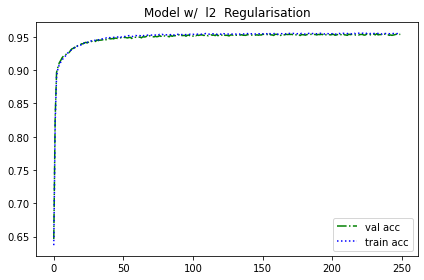

In [ ]:
plt.plot(epochs, val_acc1, label="val acc", color="green", linestyle='-.')
plt.plot(epochs, train_acc1, label="train acc", color="blue",linestyle=':')
plt.title("Model w/  l2  Regularisation")
plt.legend()
plt.tight_layout()
plt.savefig('l2.png',dpi=600)
plt.show()
torch.save(val_acc1, 'val_acc1.pt')
torch.save(train_acc1, 'train_acc1.pt')

### Model w/ Dropout:

Dropout Rates:

In [ ]:
p1=torch.tensor(0.7)
p2=torch.tensor(0.6)

In [ ]:
Dropout_model= torch.nn.Sequential(
    torch.nn.Linear(input_dim,500),
    torch.nn.Dropout(p1),
    torch.nn.ReLU(),
    torch.nn.Linear(500,500),
    torch.nn.Dropout(p2),
    torch.nn.ReLU(),
    torch.nn.Linear(500,output_dim),
    torch.nn.Softmax(dim=1)
)

Dropout_model=Dropout_model.to(dev)

Dropout_loss_func= torch.nn.CrossEntropyLoss()
Dropout_optimizer = torch.optim.Adam(Dropout_model.parameters(), lr=learning_rate)

In [ ]:
val_acc2=[]
train_acc2=[]
epochs=[]

In [ ]:
for i in range(num_epochs):

  for imgs, labels in train_loader:
    if dev is not None:
      imgs,labels=imgs.to(dev),labels.to(dev)
    out= Dropout_model(imgs.view(imgs.shape[0],-1))
    Dropout_loss=Dropout_loss_func(out,labels)
    Dropout_optimizer.zero_grad()
    Dropout_loss.backward()
    Dropout_optimizer.step()
  
  correct_val = 0
  total_val = 0
  correct_train_acc=0
  total_train_acc=0

  with torch.no_grad():
    for imgs, labels in val_loader:
      if dev is not None:
        imgs,labels=imgs.to(dev),labels.to(dev)
      outputs = Dropout_model(imgs.view(val_batch_size, -1)) 
      _, predicted = torch.max(outputs, dim=1) 
      total_val += labels.shape[0]
      correct_val += int((predicted == labels).sum())
    val_acc2.append(correct_val/total_val)

    for train_acc_imgs,train_acc_labels in train_acc_loader:
      if dev is not None:
        train_acc_imgs,train_acc_labels=train_acc_imgs.to(dev),train_acc_labels.to(dev)
    train_acc_out= Dropout_model(train_acc_imgs.view(train_acc_imgs.shape[0],-1))
    _, train_acc_predicted = torch.max(train_acc_out, dim=1)
    total_train_acc += train_acc_labels.shape[0]
    correct_train_acc += int((train_acc_predicted == train_acc_labels).sum())
    train_acc2.append(correct_train_acc/total_train_acc)
  epochs.append(i)

  if i%5==0:
    print("Epoch: %d, Loss: %f" % (i, float(Dropout_loss)))
    print("Train Accuracy: ", correct_train_acc / total_train_acc)
    print("Validation Accuracy: ", correct_val / total_val)

Epoch: 0, Loss: 1.964780
Train Accuracy:  0.5822666666666667
Validation Accuracy:  0.5874
Epoch: 5, Loss: 1.597776
Train Accuracy:  0.8676666666666667
Validation Accuracy:  0.8747
Epoch: 10, Loss: 1.582152
Train Accuracy:  0.8971
Validation Accuracy:  0.9017
Epoch: 15, Loss: 1.556439
Train Accuracy:  0.9124
Validation Accuracy:  0.9155
Epoch: 20, Loss: 1.553873
Train Accuracy:  0.9217333333333333
Validation Accuracy:  0.9206
Epoch: 25, Loss: 1.563485
Train Accuracy:  0.92975
Validation Accuracy:  0.9293
Epoch: 30, Loss: 1.521187
Train Accuracy:  0.9365833333333333
Validation Accuracy:  0.9366
Epoch: 35, Loss: 1.523583
Train Accuracy:  0.9416833333333333
Validation Accuracy:  0.9368
Epoch: 40, Loss: 1.554159
Train Accuracy:  0.94615
Validation Accuracy:  0.9414
Epoch: 45, Loss: 1.520381
Train Accuracy:  0.94855
Validation Accuracy:  0.9466
Epoch: 50, Loss: 1.517556
Train Accuracy:  0.9521833333333334
Validation Accuracy:  0.9498
Epoch: 55, Loss: 1.501342
Train Accuracy:  0.9552
Validati

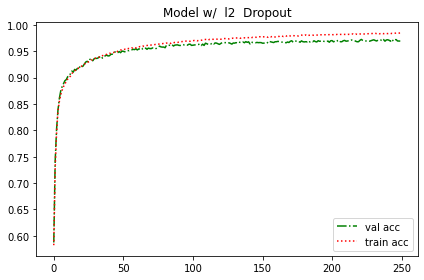

In [ ]:
plt.plot(epochs, val_acc2, label="val acc", color="green", linestyle='-.')
plt.plot(epochs, train_acc2, label="train acc", color="red",linestyle=':')
plt.title("Model w/  l2  Dropout")
plt.legend()
plt.tight_layout()
plt.savefig('drop.png',dpi=600)
plt.show()
torch.save(val_acc2, 'val_acc2.pt')
torch.save(train_acc2, 'train_acc2.pt')

### Model w/ Early Stopping

In [ ]:
ES_model= torch.nn.Sequential(
    torch.nn.Linear(input_dim,500),
    torch.nn.ReLU(),
    torch.nn.Linear(500,500),
    torch.nn.ReLU(),
    torch.nn.Linear(500,output_dim),
    torch.nn.Softmax(dim=1)
)

ES_model=ES_model.to(dev)

ES_loss_func= torch.nn.CrossEntropyLoss()
ES_optimizer = torch.optim.Adam(ES_model.parameters(), lr=learning_rate)

Train Loop w/ Early Stoppping 

In [ ]:
val_acc3=[]
train_acc3=[]
max_val_acc=-1
cont_epoch=0
epochs=[]

In [ ]:
for i in range(num_epochs):
  for imgs, labels in train_loader:
    if dev is not None:
      imgs,labels=imgs.to(dev),labels.to(dev)
    out= ES_model(imgs.view(imgs.shape[0],-1))
    ES_loss=ES_loss_func(out,labels)
    ES_optimizer.zero_grad()
    ES_loss.backward()
    ES_optimizer.step()
  
  correct_val = 0
  total_val = 0
  correct_train_acc=0
  total_train_acc=0

  with torch.no_grad():
    for imgs, labels in val_loader:
      if dev is not None:
        imgs,labels=imgs.to(dev),labels.to(dev)
      outputs = ES_model(imgs.view(val_batch_size, -1)) 
      _, predicted = torch.max(outputs, dim=1) 
      total_val += labels.shape[0]
      correct_val += int((predicted == labels).sum())
    #calc val acc
    val_acc3.append(correct_val/total_val)
    if val_acc3[i]>max_val_acc :
      max_val_acc=val_acc3[i]

    

    for train_acc_imgs,train_acc_labels in train_acc_loader:
      if dev is not None:
        train_acc_imgs,train_acc_labels=train_acc_imgs.to(dev),train_acc_labels.to(dev)
      train_acc_out=ES_model(train_acc_imgs.view(train_acc_imgs.shape[0],-1))
      _, train_acc_predicted = torch.max(train_acc_out, dim=1)
      total_train_acc += train_acc_labels.shape[0]
      correct_train_acc += int((train_acc_predicted == train_acc_labels).sum())
    #calc train acc
    train_acc3.append(correct_train_acc/total_train_acc)
    epochs.append(i)
  
  #Early Stopping
  if val_acc3[i]<max_val_acc:
    cont_epoch = cont_epoch+1
  else :
    cont_epoch =0
  if cont_epoch > 3:
    break

  if i%5==0:
    print("Epoch: %d, Loss: %f" % (i, float(ES_loss)))
    print("Train Accuracy: ", correct_train_acc / total_train_acc)
    print("Validation Accuracy: ", correct_val / total_val)

Epoch: 0, Loss: 1.601054
Train Accuracy:  0.8949833333333334
Validation Accuracy:  0.9009
Epoch: 5, Loss: 1.543099
Train Accuracy:  0.93145
Validation Accuracy:  0.9317
Epoch: 10, Loss: 1.490674
Train Accuracy:  0.9475666666666667
Validation Accuracy:  0.9433
Epoch: 15, Loss: 1.506040
Train Accuracy:  0.9574833333333334
Validation Accuracy:  0.9509
Epoch: 20, Loss: 1.485379
Train Accuracy:  0.9641833333333333
Validation Accuracy:  0.9562
Epoch: 25, Loss: 1.483134
Train Accuracy:  0.9692
Validation Accuracy:  0.9605
Epoch: 30, Loss: 1.477658
Train Accuracy:  0.97375
Validation Accuracy:  0.9642
Epoch: 35, Loss: 1.479197
Train Accuracy:  0.97775
Validation Accuracy:  0.9664
Epoch: 40, Loss: 1.467183
Train Accuracy:  0.9806666666666667
Validation Accuracy:  0.9684
Epoch: 45, Loss: 1.478278
Train Accuracy:  0.9830833333333333
Validation Accuracy:  0.9713
Epoch: 50, Loss: 1.472586
Train Accuracy:  0.9840833333333333
Validation Accuracy:  0.9724
Epoch: 55, Loss: 1.503456
Train Accuracy:  0.9

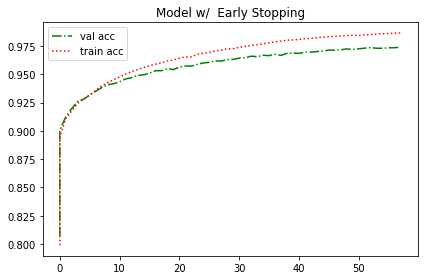

In [ ]:
plt.plot(epochs, val_acc3, label="val acc", color="green", linestyle='-.')
plt.plot(epochs, train_acc3, label="train acc", color="red",linestyle=':')
plt.title("Model w/  Early Stopping")
plt.legend()
plt.tight_layout()
plt.savefig('early.png',dpi=600)
plt.show()
torch.save(val_acc3, 'val_acc3.pt')
torch.save(train_acc3, 'train_acc3.pt')